https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24 참조

In [17]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, BatchNormalization, LSTM, Dense, concatenate, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model

import numpy as np
import random
import matplotlib.pyplot as plt
import os
import cv2
import json

# 0. GPU resource allocation

In [34]:
config = tf.compat.v1.ConfigProto()

config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.visible_device_list = "0"
session = tf.compat.v1.Session(config=config)

# 1. Define loss & base network
- 두 가지 loss 함수
    - `triplet_loss`
        - loss값이 20-40대에서 줄어들지 않음 --> 해결함
        - 출처: https://thelonenutblog.wordpress.com/2017/12/18/what-siamese-dreams-are-made-of/
    - `lossless_triplet_loss`
        - 첫 epoch부터 loss가 nan으로 나옴 --> 해결 못함
        - 출처: https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24

In [ ]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, not used in this function.
    y_pred -- python list containing three objects:
            anchor:   the encodings for the anchor data
            positive: the encodings for the positive data (similar to anchor)
            negative: the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)))

    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)))

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha

    loss = tf.maximum(basic_loss,0.0)

    return loss

def lossless_triplet_loss(y_true, y_pred, N=3, beta=3, epsilon=1e-8):
    """
    Implementation of the triplet loss function
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    N  --  The number of dimension 
    beta -- The scaling factor, N is recommended
    epsilon -- The Epsilon value to prevent ln(0)
    
    
    Returns:
    loss -- real number, value of the loss
    """
    anchor = tf.convert_to_tensor(y_pred[:,0:N])
    positive = tf.convert_to_tensor(y_pred[:,N:N*2]) 
    negative = tf.convert_to_tensor(y_pred[:,N*2:N*3])
    
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),1)
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),1)
    
    #Non Linear Values  
    
    # -ln(-x/N+1)
    pos_dist = -tf.math.log(-tf.divide((pos_dist),beta)+1+epsilon)
    neg_dist = -tf.math.log(-tf.divide((N-neg_dist),beta)+1+epsilon)
    
    # compute loss
    loss = neg_dist + pos_dist
    
    return loss

In [ ]:
def cnn_base_network(in_dims, out_dims):
    model = Sequential()

    model.add(Conv2D(input_shape = in_dims,
                     filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())    #1차원화

    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(out_dims, activation = 'relu'))

    return model

# 2. Load data

In [46]:
data_dir = './pre_DB12/'

In [47]:
batch_size = 2000

train_datagen = ImageDataGenerator(rescale=1./255 )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                        data_dir,  # this is the target directory
                        target_size=(150, 150),  # 모든 이미지의 크기가 150x150로 조정됩니다.
                        batch_size=batch_size,)

batch = train_generator.next()
images = batch[0]
labels = batch[1]

# images = images.reshape(-1, 150, 150)
labels = np.array([np.argmax(x) for x in labels])

Found 909 images belonging to 94 classes.


In [48]:
images.shape

(909, 150, 150, 3)

In [49]:
labels.shape

(909,)

## 2.1 triplet sampling

In [41]:
def get_triplets(images, sample_size):
    anchors = []
    positives = []
    negatives = []
    
    while len(anchors) < sample_size:
        num1, num2 = random.sample(range(93), 2)
        positive_pool = images[np.where(labels == num1)[0]]
        negative_pool = images[np.where(labels == num2)[0]]
        num3, num4 = random.sample(range(len(positive_pool)), 2)
                            
        anchor = positive_pool[num3]
        positive = positive_pool[num4]
        negative = images[np.where(labels == num2)][random.randint(0, len(negative_pool)-1)]

        anchors.append(anchor)
        positives.append(positive)
        negatives.append(negative)
    
    anchors = np.array(anchors)
    positives = np.array(positives)
    negatives = np.array(negatives)
    
    return anchors, positives, negatives

In [55]:
sample_size = 3000

a, p, n = get_triplets(images, sample_size)
y_dummie = np.ones(sample_size)

In [57]:
a.shape

(3000, 150, 150, 3)

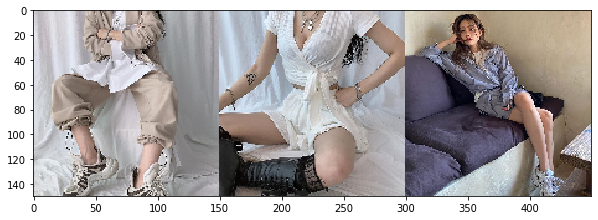

In [61]:
anchor = a[0]     # 0th anchor
positive = p[0]   # 0th positive point
negative = n[0]  # 0th negative point

triplet = np.hstack([anchor, positive, negative])

plt.figure(figsize=(10, 30))
plt.imshow(triplet)

In [115]:
images.shape

(909, 150, 150)

# 3. Create model

In [68]:
in_dims = (a.shape[1], a.shape[2], a.shape[3])
out_dims = 64

# Create the 3 inputs
anchor_in = Input(shape=in_dims)
pos_in = Input(shape=in_dims)
neg_in = Input(shape=in_dims)

# with tf.compat.v1.Session(config=config):
    # Share base network with the 3 inputs
base_network = cnn_base_network(in_dims, out_dims)
anchor_out = base_network(anchor_in)
pos_out = base_network(pos_in)
neg_out = base_network(neg_in)
    
merged_vector = concatenate([anchor_out, pos_out, neg_out], axis=-1)
# Define the trainable model
model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)
model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss=triplet_loss)

In [69]:
base_network.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 148, 148, 10)      280       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 10)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 72, 72, 64)        5824      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               10616960  
_________________________________________________________________
dense_16 (Dense)             (None, 64)              

In [70]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 64)           10631320    input_25[0][0]                   
                                                                 input_26[0][0]             

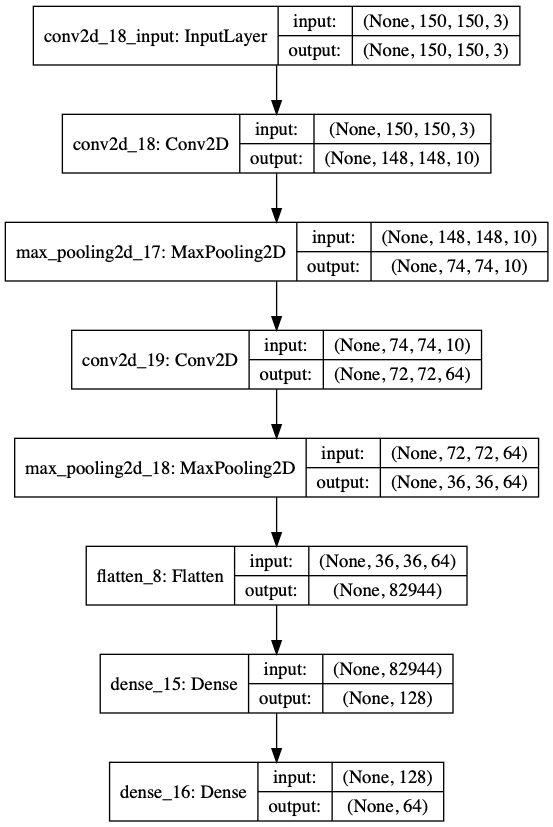

In [283]:
plot_model(base_network, to_file='./CNN/base_network.png', show_shapes=True, show_layer_names=True)

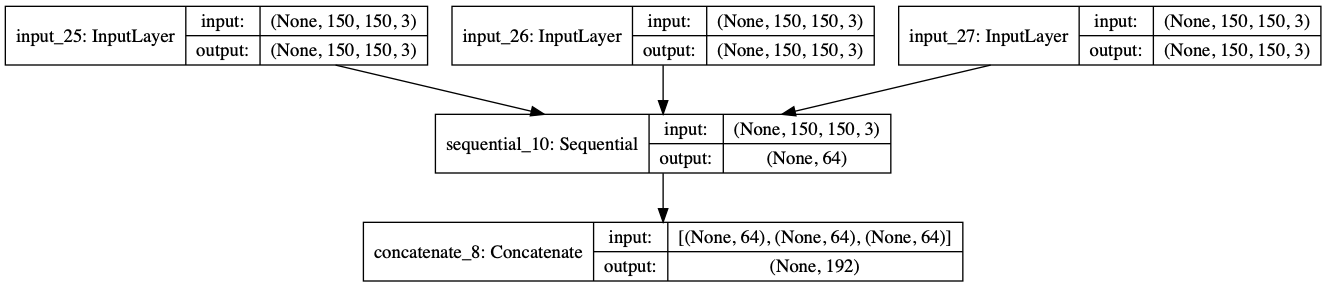

In [75]:
plot_model(model, to_file='./CNN/cnn_model.png', show_shapes=True, show_layer_names=True)

# 4. Train

In [71]:
# Training the model
H = model.fit([a, p, n], y_dummie, batch_size=50, epochs=10)

Epoch 1/10
3000/3000 [==============================] - 102s 34ms/step - loss: 0.2567
Epoch 2/10
3000/3000 [==============================] - 86s 29ms/step - loss: 0.2323
Epoch 3/10
3000/3000 [==============================] - 96s 32ms/step - loss: 0.2253
Epoch 4/10
3000/3000 [==============================] - 78s 26ms/step - loss: 0.1770
Epoch 5/10
3000/3000 [==============================] - 73s 24ms/step - loss: 0.2070
Epoch 6/10
3000/3000 [==============================] - 75s 25ms/step - loss: 0.2263
Epoch 7/10
3000/3000 [==============================] - 108s 36ms/step - loss: 0.2142
Epoch 8/10
3000/3000 [==============================] - 87s 29ms/step - loss: 0.2328
Epoch 9/10
3000/3000 [==============================] - 90s 30ms/step - loss: 0.1984
Epoch 10/10
3000/3000 [==============================] - 95s 32ms/step - loss: 0.1977


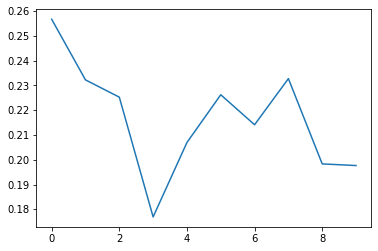

In [79]:
#결과 확인
plt.plot(H.history['loss'])
plt.savefig('./CNN/loss_graph.png')
# plt.legend(['loss'], loc = 'upper left')
plt.show()


# 5. Save model & weights

In [77]:
model_dir = './CNN/cnn_model.json'
model_weights_dir = './CNN/cnn_model.h5'

In [78]:
#Save model
model_json = model.to_json()
with open(model_dir, "w") as json_file : 
    json_file.write(model_json)

#Save weights
model.save_weights(model_weights_dir)
print("Saved model to disk")

Saved model to disk


In [ ]:
#Load model & weights
from keras.models import model_from_json json_file = open(model_dir, "r")
loaded_model_json = json_file.read() json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(model_weights_dir)
print("Loaded model from disk")

# 6. Application

In [80]:
def item_to_encoding(item, model):
    return model.predict(np.array([item]))

In [109]:
image_0_encoding = item_to_encoding(images[0], base_network)
image_0_encoding

array([[0.07781276, 0.        , 0.10325927, 0.        , 0.        ,
        0.        , 0.        , 0.1204522 , 0.        , 0.        ,
        0.        , 0.08551985, 0.        , 0.05229799, 0.07093743,
        0.        , 0.06600478, 0.00514765, 0.        , 0.01518743,
        0.01735762, 0.0252761 , 0.        , 0.        , 0.07379011,
        0.01446375, 0.        , 0.03978537, 0.        , 0.        ,
        0.03154007, 0.00119854, 0.10744961, 0.        , 0.        ,
        0.        , 0.04456974, 0.0623914 , 0.03550074, 0.        ,
        0.00611504, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.02248349, 0.        , 0.        ,
        0.        , 0.03702401, 0.        , 0.03597564, 0.        ,
        0.        , 0.12255734, 0.05004836, 0.        , 0.        ,
        0.02197458, 0.        , 0.08489778, 0.        ]], dtype=float32)

In [83]:
labels_eng = os.listdir("./pre_DB12/")
labels_eng.sort()
labels_eng.remove('.DS_Store')

In [84]:
labels_dict = dict(enumerate(labels_eng))

In [85]:
labels_dict

{0: '0.94k',
 1: '4x2a',
 2: '__kfashions',
 3: '_daisyys',
 4: '_moaol',
 5: '_noncode_',
 6: '_sosovely_',
 7: '_unjin_',
 8: 'acubi_club',
 9: 'aestheticssoul_',
 10: 'aiko_casual',
 11: 'and_more_seoul',
 12: 'andsimpleofficial',
 13: 'angelic_co_',
 14: 'arif.house',
 15: 'asyoulikeit_shop',
 16: 'beigee_au',
 17: 'bigking0720',
 18: 'bitda_com',
 19: 'blackup_kr',
 20: 'bleu_roze_',
 21: 'butterheim',
 22: 'by_lamour',
 23: 'chaedo_nayoung',
 24: 'choa_joah',
 25: 'closeclip',
 26: 'closetme_official',
 27: 'commonunique_official',
 28: 'cosmiccgirlss',
 29: 'darkvictory_official',
 30: 'ddalgiwoouuuuuuuuu',
 31: 'dressesloves',
 32: 'eden.seoul',
 33: 'etmon_official',
 34: 'femmemuse_official',
 35: 'float.un',
 36: 'frombeginning_',
 37: 'fromgirls55',
 38: 'heartberry_studio',
 39: 'hee.xox',
 40: 'honeysoymelon',
 41: 'huagaleria',
 42: 'ini_iii',
 43: 'j_blin',
 44: 'januaryrose_insta',
 45: 'jessavintage',
 46: 'k.fash10n',
 47: 'k.korean.fashion',
 48: 'k.orean.style',
 4

In [86]:
labels_dict[labels[0]]

'korean_styless_'

## 7.1 Load items to tag

In [234]:
def load_images_as_dict(folder):
    items = {}
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, (150, 150))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        items[filename.split('.')[0]] = img
    return items

In [235]:
item_dir = './seoulstore/dummie'

items_dict = load_images_as_dict(item_dir)

In [236]:
items_dict

{'189': array([[[198, 197, 193],
         [198, 197, 193],
         [199, 198, 194],
         ...,
         [196, 195, 191],
         [196, 195, 191],
         [196, 195, 191]],
 
        [[198, 197, 193],
         [198, 197, 193],
         [199, 198, 194],
         ...,
         [196, 195, 191],
         [196, 195, 191],
         [196, 195, 191]],
 
        [[198, 197, 193],
         [198, 197, 193],
         [199, 198, 194],
         ...,
         [196, 195, 191],
         [196, 195, 191],
         [196, 195, 191]],
 
        ...,
 
        [[204, 203, 201],
         [204, 203, 201],
         [205, 204, 202],
         ...,
         [173, 164, 155],
         [174, 165, 156],
         [175, 166, 157]],
 
        [[205, 204, 202],
         [205, 204, 202],
         [206, 205, 203],
         ...,
         [171, 162, 153],
         [172, 163, 154],
         [173, 164, 155]],
 
        [[205, 204, 202],
         [205, 204, 202],
         [206, 205, 203],
         ...,
         [170, 161, 1

In [112]:
thresh = 0.1

plt.figure(figsize=(150, 150))

cc = 3
rr = int(len(items[:10]) / cc)+1

plt.subplot( rr ,cc, 1)
plt.imshow(images[0], cmap = 'gray')
plt.xlabel("Anchor", fontsize=80)


for k in range(len(items[:10])):        
    i = items[k]          
    plt.subplot( rr ,cc, k+2)   # 몇 칼럼 몇 로우로 그래프 그릴지
    plt.imshow(i, cmap = 'gray')
    item_encoding = item_to_encoding(i, base_network)
    dist = np.linalg.norm(image_0_encoding-item_encoding)
    c =  "blue" if  dist < thresh  else "red"
    plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = c, fontsize=80)

In [111]:
thresh = 0.1

plt.figure(figsize=(150, 150))

cc = 3
rr = int(len(items[:10]) / cc)+1

plt.subplot( rr ,cc, 1)
plt.imshow(images[1], cmap = 'gray')
plt.xlabel("Anchor", fontsize=80)


for k in range(len(items[:10])):        
    i = items[k]          
    plt.subplot( rr ,cc, k+2)   # 몇 칼럼 몇 로우로 그래프 그릴지
    plt.imshow(i, cmap = 'gray')
    item_encoding = item_to_encoding(i, base_network)
    dist = np.linalg.norm(image_1_encoding-item_encoding)
    c =  "blue" if  dist < thresh  else "red"
    plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = c, fontsize=80)

In [110]:
thresh = 0.1

plt.figure(figsize=(150, 150))

cc = 3
rr = int(len(items[:10]) / cc)+1

plt.subplot( rr ,cc, 1)
plt.imshow(images[2], cmap = 'gray')
plt.xlabel("Anchor", fontsize=80)


for k in range(len(items[:10])):        
    i = items[k]          
    plt.subplot( rr ,cc, k+2)   # 몇 칼럼 몇 로우로 그래프 그릴지
    plt.imshow(i, cmap = 'gray')
    item_encoding = item_to_encoding(i, base_network)
    dist = np.linalg.norm(image_2_encoding-item_encoding)
    c =  "blue" if  dist < thresh  else "red"
    plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = c, fontsize=80)

In [266]:
def identify_item(item, database, model, thresh_dist=0.1):
    """
    Implements item recognition.
    Arguments:
    item -- the item to identify
    database -- database containing recognized item encodings
    model -- the encoding model
    thresh_dist -- maximum distance between item-identity to be considered
        being of 'similar styles'
    Returns:
    identity_dist -- dictionary containing identity:distance pairs which 
        satisfy the distance maximum given as thresh_dist
    """

    # Compute the target "encoding" for the traffic.
    encoding = item_to_encoding(item, model)

    # Find the closest encoding

    identity_dist = {}
    
    for (name, db_encs) in database.items():
     # Compute L2 distance between the target "encoding" and the current "emb" from the database.
        for enc in db_encs:
            dist = np.linalg.norm(enc-encoding)

            # If this distance is less than the thresh_dist, then add identity:distance pair to identity_dist
            if dist < thresh_dist:
                identity_dist[name] = str(dist)    #because json cannot save float32
                break

    return identity_dist

In [99]:
# create encoding database with insta images
database = {}

for k in range(len(images)):
    if database.get(labels_eng[labels[k]]) != None:
        database[labels_eng[labels[k]]].append(item_to_encoding(images[k], base_network))
    else:
        database[labels_eng[labels[k]]] = [item_to_encoding(images[k], base_network)]

In [125]:
# Prediction on item
similar_styles = identify_item(items[0], database, base_network, 0.03)
similar_styles

{'uau__shop': 0.026308946,
 'marhenbreeze_official': 0.02979614,
 '_noncode_': 0.024152417,
 'angelic_co_': 0.029026119,
 'beigee_au': 0.024907574}

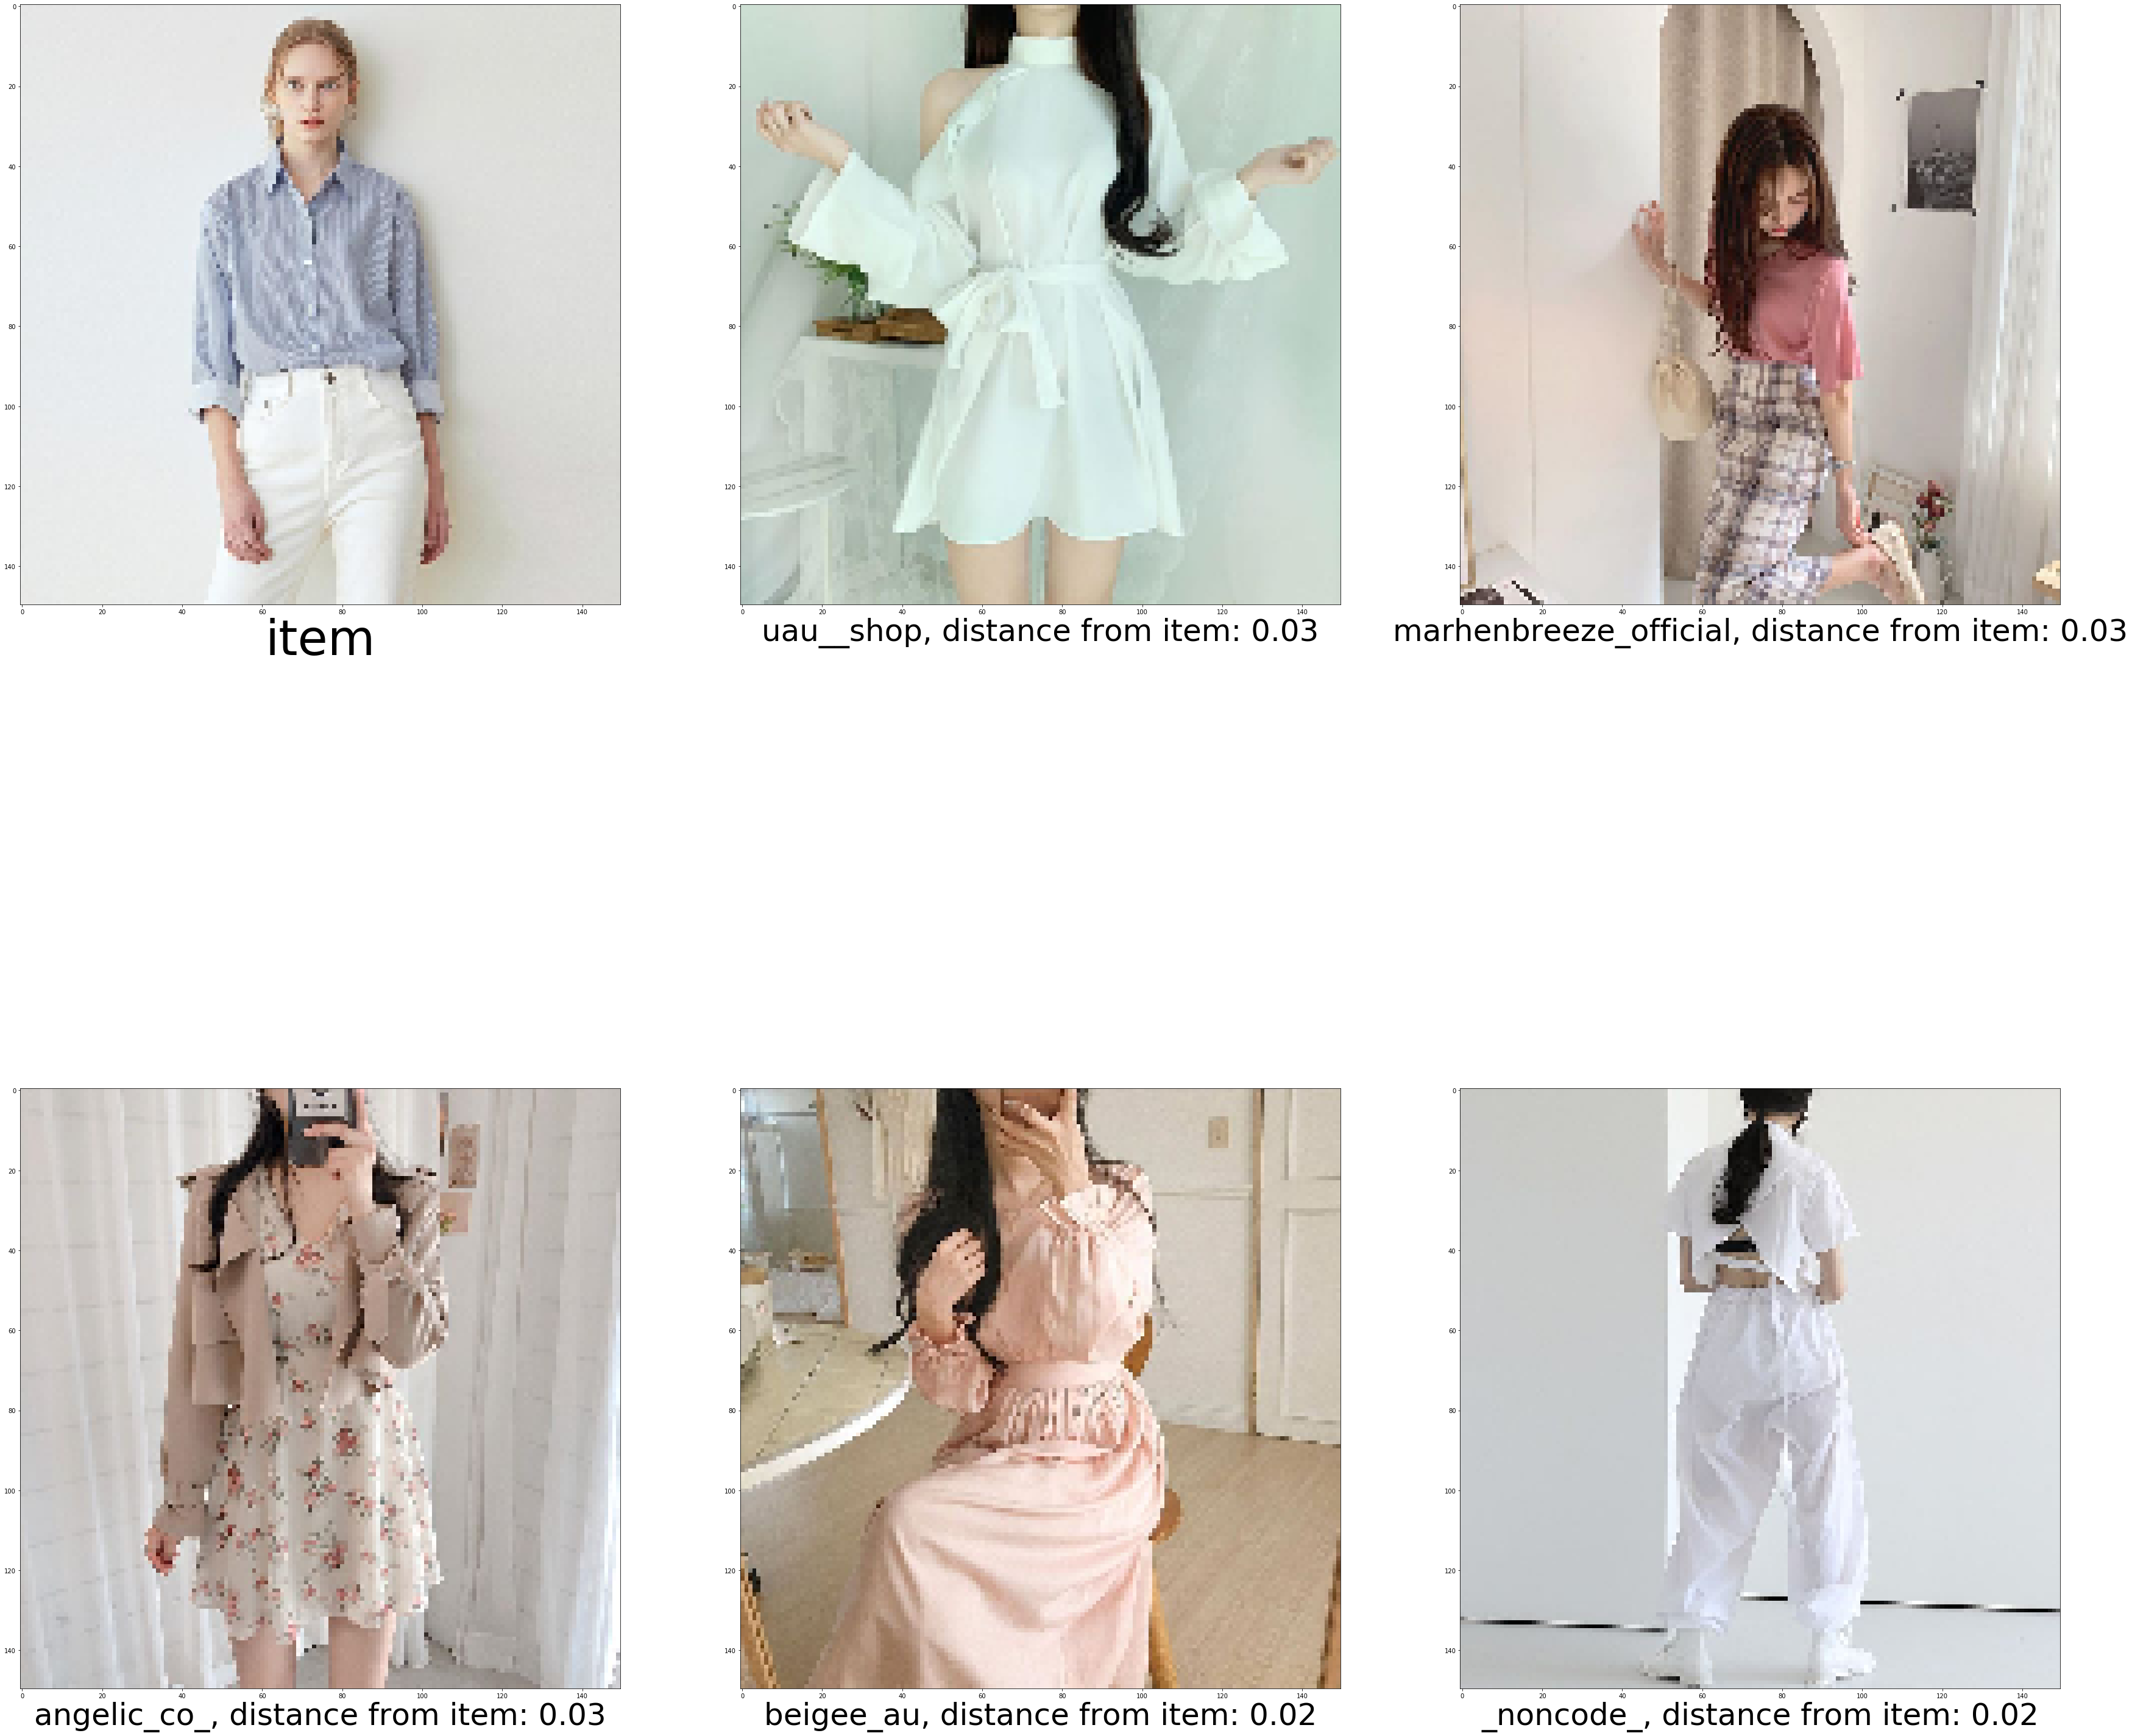

In [135]:
plt.figure(figsize=(60, 60))

cc = 3
rr = int(len(similar_styles) / cc)+1

plt.subplot(rr ,cc, 1)
plt.imshow(items[0], cmap = 'gray')
plt.xlabel("item", fontsize=80)

count = 0

for k in range(len(images)): 
    image = images[k]
    image_encoding = item_to_encoding(image, base_network)  
    dist = np.linalg.norm(image_encoding-item_encoding) 
    if dist < 0.03:
        count += 1
        num_label = labels[k]
        eng_label = labels_dict[num_label]
        plt.subplot( rr ,cc, count+1)   # 몇 칼럼 몇 로우에 그래프 그릴지
        plt.imshow(image)
        plt.xlabel("{}, distance from item: {:.2f}".format(eng_label, dist),fontsize=50)       

In [ ]:
plt.figure(figsize=(60, 60))

cc = 3
rr = int(len(similar_styles) / cc)+1

plt.subplot(rr ,cc, 1)
plt.imshow(items[0], cmap = 'gray')
plt.xlabel("item", fontsize=80)

count = 0

for k in range(len(images)): 
    image = images[k]
    image_encoding = item_to_encoding(image, base_network)  
    dist = np.linalg.norm(image_encoding-item_encoding) 
    if dist < 0.03:
        count += 1
        num_label = labels[k]
        eng_label = labels_dict[num_label]
        plt.subplot( rr ,cc, count+1)   # 몇 칼럼 몇 로우에 그래프 그릴지
        plt.imshow(image)
        plt.xlabel("{}, distance from item: {:.2f}".format(eng_label, dist),fontsize=50)       

## 7.2 Tag items

### 7.2.1 Load original json file to append data

In [173]:
# load original json file
with open(json_path, "r", encoding="utf8") as f:
    url_data = json.load(f, encoding = 'utf-8')

In [ ]:
# reformat original json file
count = 0
for data in url_data:
    data['product_url'] = data['key']
    data['key'] = '{:03d}'.format(count)
    count += 1

In [180]:
url_data

[{'img_url': 'https://images.seoulstore.com/products/7f3ce89482c81a3b19fb354229099456.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1034006/detail',
  'key': '000'},
 {'img_url': 'https://images.seoulstore.com/products/b0f2118dea5df431cbda0d0df7bf97ee.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1033985/detail',
  'key': '001'},
 {'img_url': 'https://images.seoulstore.com/products/7a1290b26d9d97727fed159c3dcd9787.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1156713/detail',
  'key': '002'},
 {'img_url': 'https://images.seoulstore.com/products/f18808eb779908fac372ef1889d9305e.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1157389/detail',
  'key': '003'},
 {'img_url': 'https://images.seoulstore.com/products/873051287385fff1f4a0bb730b677691.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1178983/detail',
  'key': '004'},
 {'img_url': 'https://images.seoulstore.com/p

In [238]:
sorted_items_dict = dict(sorted(items_dict.items()))

In [239]:
sorted_items_dict

{'000': array([[[186, 171, 137],
         [187, 172, 139],
         [187, 172, 139],
         ...,
         [ 65,  52,  41],
         [ 86,  69,  56],
         [ 39,  19,  10]],
 
        [[187, 172, 139],
         [188, 173, 140],
         [191, 176, 143],
         ...,
         [ 40,  30,  19],
         [ 37,  26,  17],
         [ 34,  21,  14]],
 
        [[182, 167, 134],
         [189, 174, 141],
         [191, 176, 143],
         ...,
         [105,  94,  74],
         [ 68,  55,  46],
         [ 35,  25,  21]],
 
        ...,
 
        [[177, 161, 128],
         [181, 165, 132],
         [181, 164, 131],
         ...,
         [ 11,  11,  11],
         [ 12,  12,  12],
         [ 11,  11,  11]],
 
        [[183, 167, 134],
         [184, 168, 135],
         [183, 167, 134],
         ...,
         [ 13,  13,  13],
         [ 12,  12,  12],
         [ 12,  12,  12]],
 
        [[180, 163, 131],
         [181, 165, 132],
         [183, 167, 134],
         ...,
         [ 11,  11,  

In [240]:
len(sorted_items_dict) == len(url_data)

True

In [241]:
keys_list = list(sorted_items_dict.keys())

In [242]:
for k in range(len(keys_list)):
    print( keys_list[k] == url_data[k]['key'])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [278]:
for k in range(len(keys_list)):
    key = keys_list[k]
    similar_styles = identify_item(items_dict[key]/255., database, base_network, 0.05)
#     print( similar_styles != {} )
    if key == url_data[k]['key']:
        url_data[k]['likely'] = similar_styles

In [279]:
url_data

[{'img_url': 'https://images.seoulstore.com/products/7f3ce89482c81a3b19fb354229099456.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1034006/detail',
  'key': '000',
  'likely': {'januaryrose_insta': '0.046844076',
   'and_more_seoul': '0.049897134'}},
 {'img_url': 'https://images.seoulstore.com/products/b0f2118dea5df431cbda0d0df7bf97ee.jpg?d=640xauto',
  'product_url': 'https://www.seoulstore.com/products/1033985/detail',
  'key': '001',
  'likely': {'korean_styless_': '0.03981472',
   'asyoulikeit_shop': '0.04885481',
   'uau__shop': '0.0454914',
   'rosemelon.kr': '0.048884925',
   'someday__s': '0.0331893',
   'j_blin': '0.04953617',
   'jessavintage': '0.044505827',
   '_daisyys': '0.044975378',
   'maysome_official': '0.045360528',
   '4x2a': '0.043121725',
   'mori__closet': '0.046707377',
   'andsimpleofficial': '0.0371679',
   'and_more_seoul': '0.04784448',
   'marhenbreeze_official': '0.032038815',
   'myojaeng': '0.039229285',
   'bigking0720': '0.03

## 7.3 Save result as json

In [280]:
def output(data, filepath):
    out = json.dumps(data, ensure_ascii=False)
    if filepath:
        with open(filepath, "a", encoding="utf8") as f:
            f.write(out)
            print("successfully saved file")
    else:
        with open(filepath, "w", encoding="utf8") as f:
            f.write(out)
    return out

In [281]:
filepath = './seoulstore_tagged_05.json'

out = output(url_data, filepath)

successfully saved file


In [282]:
parsed = json.loads(out)
print(json.dumps(parsed, indent=4, sort_keys=True))

[
    {
        "img_url": "https://images.seoulstore.com/products/7f3ce89482c81a3b19fb354229099456.jpg?d=640xauto",
        "key": "000",
        "likely": {
            "and_more_seoul": "0.049897134",
            "januaryrose_insta": "0.046844076"
        },
        "product_url": "https://www.seoulstore.com/products/1034006/detail"
    },
    {
        "img_url": "https://images.seoulstore.com/products/b0f2118dea5df431cbda0d0df7bf97ee.jpg?d=640xauto",
        "key": "001",
        "likely": {
            "0.94k": "0.03616242",
            "4x2a": "0.043121725",
            "_daisyys": "0.044975378",
            "_noncode_": "0.04005536",
            "acubi_club": "0.04790125",
            "aestheticssoul_": "0.03442119",
            "and_more_seoul": "0.04784448",
            "andsimpleofficial": "0.0371679",
            "angelic_co_": "0.04440499",
            "arif.house": "0.048768602",
            "asyoulikeit_shop": "0.04885481",
            "beigee_au": "0.033273064",
       

# 부록. 흑역사

In [15]:
def create_base_network(in_dims, out_dims):
    """
    Base network to be shared.
    """
    model = Sequential()
    model.add(BatchNormalization(input_shape=in_dims))
    model.add(LSTM(512, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, implementation=2))
    model.add(LSTM(512, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, implementation=2))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(254, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(254, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(out_dims, activation='sigmoid'))
    model.add(BatchNormalization())

    return model

In [29]:
in_dims = (150, 150)
out_dims = 64


# Create the 3 inputs
anchor_in = Input(shape=in_dims)
pos_in = Input(shape=in_dims)
neg_in = Input(shape=in_dims)


# with tf.compat.v1.Session(config=config):
    # Share base network with the 3 inputs
base_network = create_base_network(in_dims, out_dims)
anchor_out = base_network(anchor_in)
pos_out = base_network(pos_in)
neg_out = base_network(neg_in)
    
merged_vector = concatenate([anchor_out, pos_out, neg_out], axis=-1)
# Define the trainable model
model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)
model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss=triplet_loss)

In [30]:
base_network.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_25 (Batc (None, 150, 150)          600       
_________________________________________________________________
lstm_7 (LSTM)                (None, 150, 512)          1357824   
_________________________________________________________________
lstm_8 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
batch_normalization_26 (Batc (None, 512)               2048      
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_27 (Batc (None, 512)               2048      
_________________________________________________________________
dense_20 (Dense)             (None, 254)              

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 150, 150)     0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 150, 150)     0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 150, 150)     0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 64)           3967560     input_16[0][0]                   
                                                                 input_17[0][0]             

In [36]:
# Training the model
H = model.fit([a, p, n], y_dummie, batch_size=20, epochs=20)

Epoch 1/20
3000/3000 [==============================] - 97s 32ms/step - loss: 27.6017
Epoch 2/20
3000/3000 [==============================] - 97s 32ms/step - loss: 25.9174
Epoch 3/20
3000/3000 [==============================] - 97s 32ms/step - loss: 29.6035
Epoch 4/20
3000/3000 [==============================] - 97s 32ms/step - loss: 29.6684
Epoch 5/20
3000/3000 [==============================] - 97s 32ms/step - loss: 26.7978
Epoch 6/20
3000/3000 [==============================] - 97s 32ms/step - loss: 29.5860
Epoch 7/20
3000/3000 [==============================] - 97s 32ms/step - loss: 28.7015
Epoch 8/20
3000/3000 [==============================] - 97s 32ms/step - loss: 22.1870
Epoch 9/20
3000/3000 [==============================] - 97s 32ms/step - loss: 34.2097
Epoch 10/20
3000/3000 [==============================] - 97s 32ms/step - loss: 29.6183
Epoch 11/20
3000/3000 [==============================] - 96s 32ms/step - loss: 29.9013
Epoch 12/20
3000/3000 [=============================

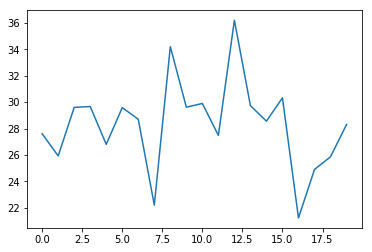

In [171]:
#결과 확인
plt.plot(H.history['loss'])
# plt.legend(['loss'], loc = 'upper left')
plt.show()